# Notebook on Demo Use Case for Counterfactual Explanations

This notebook demonstrates a practical use case of the eNNcode library using counterfactual explanations on the MNIST dataset. Therefore, we first import the necessary packages for this demo.

In [2]:
from gurobipy import GRB
from enncode.gurobiModelBuilder import GurobiModelBuilder

from examples.data import get_mnist_batch
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort

We also load a small subset of original data points from the MNIST dataset. For all visualized examples, counterfactual explanations are sought iteratively in the same way.

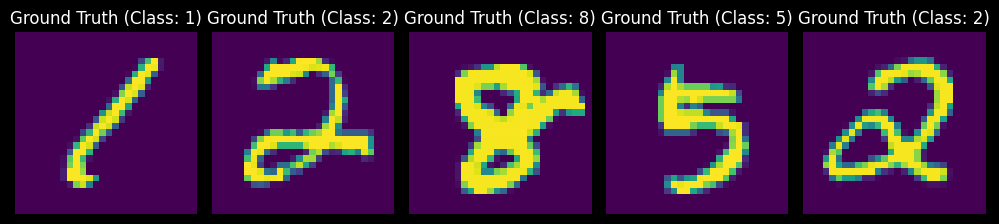

In [4]:
mnist_inputs, labels = get_mnist_batch(5, flatten=True)
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    axes[i].imshow(np.array(mnist_inputs[i]).reshape((28, 28)), cmap='viridis')
    axes[i].set_title(f"Ground Truth (Class: {labels[i]})")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


For this demonstration, we use a simple CNN trained on MNIST. We pass this to the constructor of the <em>GurobiModelBuilder</em> class. Then we call the <em>build_model()</em> function, which implements the network encoding step by step. For further implementation, we also obtain the GurobiModel and the input and output variables.

In [5]:
# Path to the ONNX Net-file
conv_onnx = "data/conv_net.onnx"
model_builder = GurobiModelBuilder(conv_onnx)
model_builder.build_model()

gurobi_model = model_builder.get_gurobi_model()
input_vars = model_builder.get_input_vars()
output_vars = model_builder.get_output_vars()

Set parameter Username
Set parameter LicenseID to value 2734490
Academic license - for non-commercial use only - expires 2026-11-07


We then implement the following loop. In each iteration, a data point from MNIST is used. Starting from this point, we search for the input with the minimum L1 distance, which is assigned to a random class by the network. Note that the following code is further commented within the cell.

Set parameter TimeLimit to value 30


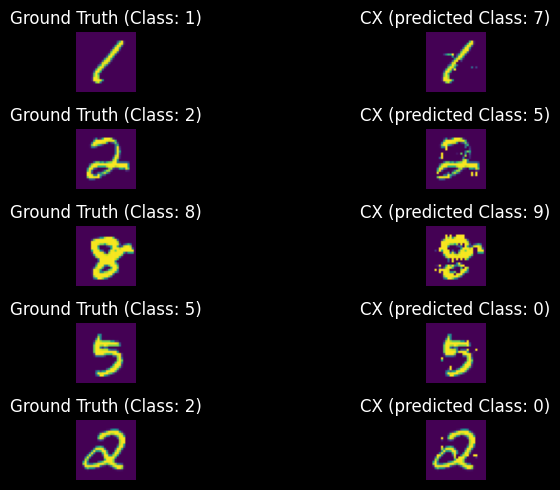

In [6]:
# This is only to visualize the found solutions
fig, axes = plt.subplots(5, 2, figsize=(10, 5))

# (Optional) parameters to the gurobi model
gurobi_model.setParam("TimeLimit", 30)
gurobi_model.setParam("OutputFlag", 0)

# We store the new constraints in each iteration, so we can delete them afterward and reuse the same GurobiModel.
tmp_constraints = []
for idx in range(mnist_inputs.shape[0]):
    mnist_input = mnist_inputs[idx]
    label = labels[idx]

    # We bound all input variables to be between 0 and 1
    gurobi_model.setAttr("LB", list(input_vars.values()), 0.0)
    gurobi_model.setAttr("UB", list(input_vars.values()), 1.0)

    # For encoding the objective, do minimize the L1 distance, additional distance variables are needed
    dist_vars = gurobi_model.addVars(len(input_vars), name="dist_vars")
    for flat_idx, (_, input_var) in enumerate(input_vars.items()):
        dist_var = dist_vars[flat_idx]
        # We encode that each distance variable is equal to |real_input_value - input_variable|
        c1 = gurobi_model.addConstr(dist_var >= mnist_input[flat_idx] - input_var)
        c2 = gurobi_model.addConstr(dist_var >= input_var - mnist_input[flat_idx])
        tmp_constraints.append([c1, c2])

    # A random target class is selected, that differs from the original GT label
    target_class = np.random.randint(0, 10)
    while target_class == label:
        target_class = np.random.randint(0, 10)

    # Now the output variable of the desired output class is obtained
    target_idx = list(output_vars.keys())[target_class]
    for flat_idx, (_, output_var) in enumerate(output_vars.items()):
        # We encode that the activation of the targeted output variable is greater than all other output variables
        if target_class != flat_idx:
            c_dist = gurobi_model.addConstr(output_vars[target_idx] >= output_var + 0.001)
            tmp_constraints.append([c_dist])

    # Then the objective is defined: minimize the sum over all distance variables
    gurobi_model.setObjective(dist_vars.sum(), GRB.MINIMIZE)
    gurobi_model.optimize()

    # Once Gurobi is done optimizing, the assignment of the input variables is obtained
    results = []
    for input_var in input_vars.values():
        results.append(input_var.X)
    cx = np.array(results).reshape((28, 28))

    # Cleanup for next iteration
    gurobi_model.remove(tmp_constraints)

    # Visualization of the found CX
    axes[idx][0].imshow(np.array(mnist_input).reshape((28, 28)), cmap='viridis')
    axes[idx][0].set_title(f"Ground Truth (Class: {label})")
    axes[idx][0].axis('off')

    axes[idx][1].imshow(cx, cmap='viridis')
    axes[idx][1].set_title(f"CX (predicted Class: {target_class})")
    axes[idx][1].axis('off')

# visualize the found solutions
plt.tight_layout()
plt.show()